<a href="https://colab.research.google.com/github/100milliongold/I-want-to-be-a-data-scientist/blob/main/Python/rapids-%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [2]:
!nvidia-smi

Thu Dec 17 19:43:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
1. removes incompatible files
1. Install RAPIDS 0.14 libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. xgboost and dask-xgboost
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
1. If running v0.11 or higher, updates pyarrow library to 0.15.x.

In [3]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  

# cuDF and cuML Examples #

Now you can run code! 

What follows are basic examples where all processing takes place on the GPU.

#[cuDF](https://github.com/rapidsai/cudf)#

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

_Note_: You must import nvstrings and nvcategory before cudf, else you'll get errors.

In [4]:
!find / -name libllvmlite.so*


/usr/local/lib/python3.6/dist-packages/llvmlite/binding/libllvmlite.so
/usr/local/lib/python3.6/site-packages/llvmlite/binding/libllvmlite.so
/usr/local/lib/python2.7/dist-packages/llvmlite/binding/libllvmlite.so
/usr/local/pkgs/llvmlite-0.32.1-py36hfa65bc7_0/lib/python3.6/site-packages/llvmlite/binding/libllvmlite.so
/usr/local/pkgs/llvmlite-0.33.0-py36hfa65bc7_1/lib/python3.6/site-packages/llvmlite/binding/libllvmlite.so
find: ‘/proc/15358/task/15358/net’: Invalid argument
find: ‘/proc/15358/net’: Invalid argument
/content/libllvmlite.so


In [5]:
!cp /usr/local/lib/python3.6/dist-packages/llvmlite/binding/libllvmlite.so .

In [6]:
!conda install -y -c conda-forge numba==0.49.1

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [7]:
!conda install -y -c conda-forge cudf

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [8]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

size
1    21.729202
2    16.571919
3    15.215685
4    14.594901
5    14.149549
6    15.622920
Name: tip_percentage, dtype: float64


#[cuML](https://github.com/rapidsai/cuml)#

This snippet loads a 

As above, all calculations are performed on the GPU.

In [9]:
import cuml

# Create and populate a GPU DataFrame
df_float = cudf.DataFrame()
df_float['0'] = [1.0, 2.0, 5.0]
df_float['1'] = [4.0, 2.0, 1.0]
df_float['2'] = [4.0, 2.0, 1.0]

# Setup and fit clusters
dbscan_float = cuml.DBSCAN(eps=1.0, min_samples=1)
dbscan_float.fit(df_float)

print(dbscan_float.labels_)

0    0
1    1
2    2
dtype: int32


# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

# Google Colab 을 위한 코드
## Colab 에서 실행을 위한 코드
- 아래의 코드는 google colaboratory 에서 실행을 위한 코드로 로컬 아나콘다에서는 주석처리합니다.
- google colaboratory 에서는 주석을 풀고 폰트 설정과 csv 파일을 불러옵니다

In [32]:
# pandas, numpy, seaborn을 불러옵니다.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null

!ls -al /usr/share/fonts/truetype/nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

import matplotlib.font_manager as fm

font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 



total 28852
drwxr-xr-x 2 root root    4096 Dec 17 19:31 .
drwxr-xr-x 1 root root    4096 Dec 17 19:31 ..
-rw-r--r-- 1 root root 4413912 Dec  3  2017 NanumBarunGothicBold.ttf
-rw-r--r-- 1 root root 4184028 Dec  3  2017 NanumBarunGothic.ttf
-rw-r--r-- 1 root root 4642244 Dec  3  2017 NanumGothicBold.ttf
-rw-r--r-- 1 root root 4691820 Dec  3  2017 NanumGothic.ttf
-rw-r--r-- 1 root root 4183592 Dec  3  2017 NanumMyeongjoBold.ttf
-rw-r--r-- 1 root root 3839464 Dec  3  2017 NanumMyeongjo.ttf
-rw-r--r-- 1 root root  733500 Dec  3  2017 NanumSquareB.ttf
-rw-r--r-- 1 root root 1030948 Dec  3  2017 NanumSquareRoundB.ttf
-rw-r--r-- 1 root root 1063276 Dec  3  2017 NanumSquareRoundR.ttf
-rw-r--r-- 1 root root  723640 Dec  3  2017 NanumSquareR.ttf
-rw-r--r-- 1 root root      36 Dec 17 19:31 .uuid


In [12]:
# 폰트가 선명하게 보이도록 retina 설정
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


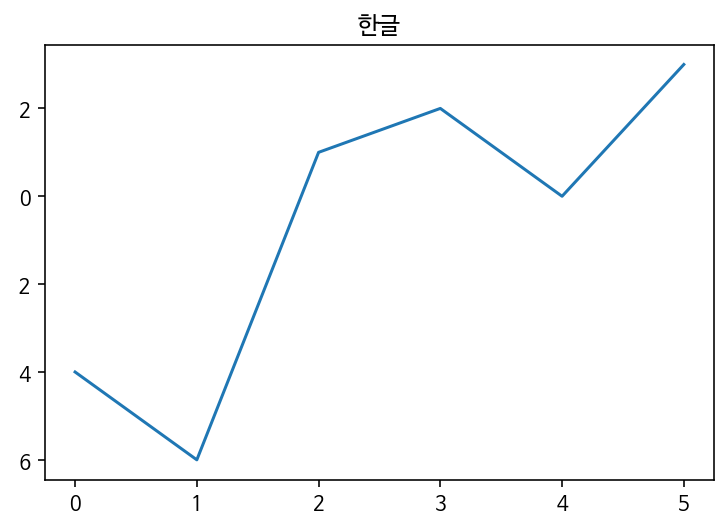

In [13]:
# 한글폰트와 마이너스 폰트 설정 확인
plt.title('한글')
plt.plot([-4,-6,1,2,0,3])

# Colab 용 GoogleAuth 인증
*   구글 드라이브에 있는 파일을 가져오기 위해 사용합니다.

In [14]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# PyDrive client 인증
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [15]:
# 공유 가능한 링크로 파일 가져오기
url = 'https://drive.google.com/open?id=1e91PH_KRFxNXUsx8Hi-Q2vPiorCDsOP4'
id = url.split('=')[1]
print(id)
downloaded = drive.CreateFile({'id':id}) 
# data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.
%mkdir data
downloaded.GetContentFile('data/상가업소정보_201912_01.csv') 

1e91PH_KRFxNXUsx8Hi-Q2vPiorCDsOP4
mkdir: cannot create directory ‘data’: File exists


## 데이터 불러오기
* 공공데이터 포털 : https://www.data.go.kr/dataset/15012005/fileData.do
* 영상에 사용한 데이터셋 : http://bit.ly/open-data-set-folder (공공데이터포털에서 다운로드 받은 파일이 있습니다. 어떤 파일을 다운로드 받아야 될지 모르겠다면 여기에 있는 파일을 사용해 주세요.)

In [36]:
# 파일을 불러와 df 라는 변수에 담습니다.
# shape 를 통해 불러온 csv 파일의 크기를 확인합니다.
df = cudf.read_csv('data/상가업소정보_201912_01.csv', sep="|")
df.shape

(573680, 39)

### 데이터 미리보기

In [35]:
df.head()

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,19905471,와라와라호프,None,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,기타 주점업,11,서울특별시,11680,강남구,1168060000,대치1동,1168010600,대치동,1168010600206040000,1,대지,604,null,서울특별시 강남구 대치동 604,116802000003,서울특별시 강남구 남부순환로,2933,null,1168010600106040000014378,대치상가,서울특별시 강남구 남부순환로 2933,135280,6280.0,None,1,None,127.061026,37.493922
1,19911397,커피빈코리아선릉로93길점,코리아선릉로93길점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11680,강남구,1168064000,역삼1동,1168010100,역삼동,1168010100206960042,1,대지,696,42.0,서울특별시 강남구 역삼동 696-42,116804166502,서울특별시 강남구 선릉로93길,6,null,1168010100106960042022041,None,서울특별시 강남구 선릉로93길 6,135080,6149.0,None,1,None,127.047883,37.505675
2,19911801,프로포즈,None,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,기타 주점업,11,서울특별시,11545,금천구,1154563000,독산3동,1154510200,독산동,1154510200201620001,1,대지,162,1.0,서울특별시 금천구 독산동 162-1,115453117003,서울특별시 금천구 가산로,34,6.0,1154510200101620001017748,None,서울특별시 금천구 가산로 34-6,153010,8545.0,None,1,None,126.899220,37.471711
3,19912201,싱싱커피&토스트,None,Q,음식,Q07,패스트푸드,Q07A10,토스트전문,I56192,"피자, 햄버거, 샌드위치 및 유사 음식점업",26,부산광역시,26530,사상구,2653062000,괘법동,2653010400,괘법동,2653010400205780000,1,대지,578,null,부산광역시 사상구 괘법동 578,265303139004,부산광역시 사상구 괘감로,37,null,2653010400105780000002037,산업용품유통상가,부산광역시 사상구 괘감로 37,617726,46977.0,None,1,26,128.980455,35.159774
4,19932756,가락사우나내스낵,None,F,생활서비스,F09,대중목욕탕/휴게,F09A02,사우나/증기탕/온천,S96121,욕탕업,11,서울특별시,11710,송파구,1171060000,석촌동,1171010500,석촌동,1171010500202560000,1,대지,256,null,서울특별시 송파구 석촌동 256,117103123001,서울특별시 송파구 가락로,71,null,1171010500102560005010490,None,서울특별시 송파구 가락로 71,138846,5690.0,None,1,None,127.104071,37.500249


 ### info 보기

In [40]:
# info 를 사용하면 데이터의 전체적인 정보를 볼 수 있습니다.
# 데이터의 사이즈, 타입, 메모리 사용량 등을 볼 수 있습니다.


,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573675,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,True,False,False
573676,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False
573677,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False
573678,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False


### 결측치 보기

In [66]:
# isnull() 을 사용하면 데이터의 결측치를 볼 수 있습니다.
# 결측치는 True로 값이 있다면 False로 표시되는데 True 는 1과 같기 때문에 
# True 값을 sum()을 사용해서 더하게 되면 합계를 볼 수 있습니다.
(df.isnull().sum().index,  df.isnull().sum().values)

(StringIndex(['상가업소번호' '상호명' '지점명' '상권업종대분류코드' '상권업종대분류명' '상권업종중분류코드' '상권업종중분류명'
  '상권업종소분류코드' '상권업종소분류명' '표준산업분류코드' '표준산업분류명' '시도코드' '시도명' '시군구코드' '시군구명'
  '행정동코드' '행정동명' '법정동코드' '법정동명' '지번코드' '대지구분코드' '대지구분명' '지번본번지' '지번부번지'
  '지번주소' '도로명코드' '도로명' '건물본번지' '건물부번지' '건물관리번호' '건물명' '도로명주소' '구우편번호'
  '신우편번호' '동정보' '층정보' '호정보' '경도' '위도'], dtype='object'),
 array([     0,      1, 497006,      0,      0,      0,      0,      0,
             0,  34390,  34390,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,  98756,
             0,      0,      0,      0, 501692,      0, 308072,      0,
             0,      9, 522824, 226553, 488414,      0,      0]))